In [6]:
from transformer_lens import HookedTransformer
import torch
from IPython.display import Image, SVG
import transformer_lens

import connectome.core as core
from connectome.interventions import (
        CorruptIntervention,
        CropIntervention,
        DampenIntervention,
        ZeroPattern,
)
from connectome.strategies import BasicStrategy, BisectStrategy, SplitStrategy
from connectome.plotting import attn_connectome, plot_attn_connectome, plot_graphviz_connectome
from connectome.metrics import logit_diff_metric


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Code Completion

In [3]:
# load Pythia 2.8b
torch.set_grad_enabled(False)
pythia = HookedTransformer.from_pretrained("pythia-2.8b", device="cpu")
pythia.to("cuda")

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-2.8b into HookedTransformer


In [5]:
CODE_PROMPT = """
from typing import List
from math import pi

class Point:
    def __init__(self, x: float, y: float) -> None:
        self.x = x
        self.y = y

class A:
    def __init__(self, bottom_left: Point, top_right: Point) -> None:
        self.bottom_left = bottom_left
        self.top_right = top_right
        
class B:
    def __init__(self, center: Point, radius: float) -> None:
        self.center = center
        self.radius = radius

class C:
    def __init__(self, points: List[Point]) -> None:
        self.points = points

def calculate_area(rectangle: A) -> float:
    height = rectangle.top_right.y - rectangle.bottom_left.y
    width = rectangle.top_right.x - rectangle.bottom_left.x
    return height * width

def calculate_center(rectangle: A) -> Point:
    center_x = (rectangle.bottom_left.x + rectangle.top_right.x) / 2
    center_y = (rectangle.bottom_left.y + rectangle.top_right.y) / 2
    return Point(center_x, center_y)

def calculate_distance(point1: Point, point2: Point) -> float:
    return ((point2.x - point1.x) ** 2 + (point2.y - point1.y) ** 2) ** 0.5

def calculate_circumference(circle: B) -> float:
    return 2 * pi * circle.radius

def calculate_circle_area(circle: B) -> float:
    return pi * (circle.radius ** 2)

def calculate_perimeter(polygon: C) -> float:
    perimeter = 0
    points = polygon.points + [polygon.points[0]]  # Add the first point at the end for a closed shape
    for i in range(len(points) - 1):
        perimeter += calculate_distance(points[i], points[i + 1])
    return perimeter

foo = A(Point(2, 3), Point(6, 5))

bar = B(Point(0, 0), 5)

name = C([Point(0, 0), Point(1, 0), Point(0, 1)])

# Calculate circumference
print(calculate_circumference("""



In [ ]:
c = core.connectome(pythia, CODE_PROMPT,
        logit_diff_metric(pythia, ' bar', ' foo', ' name'),
        ZeroPattern(),
        # core.BisectStrategy(0.1),
        # core.BacktrackingStrategy(threshold),
        SplitStrategy(
            pythia, 
            CODE_PROMPT, 
            0.5, 
            delimiters=(
                '\n',
                tuple('.!?'),
                tuple(',:;'),
            ),  
        tokens_as_leaves=False),
        max_batch_size=10
)

## Question Answering

In [3]:
QA_PROMPT = """Here is a short story. Read it carefully and answer the questions below.

As the sun reached its zenith, casting a warm glow on the bustling streets, Christopher 
contemplated his daily routine. With a sense of pride, he reflected on his work as a veterinarian, 
healing and caring for the animals of Valencia. He loved the vibrant city, its lively atmosphere and 
charm providing inspiration for his passion. In the calm afternoon hours, he cherished the solitude 
and peace that enveloped his clinic, allowing him to focus on his thoughts. The fragrant spring air 
invigorated him, stirring the blossoming flowers that swayed in the gentle breeze. With each 
brushstroke, Christopher let go of his stress and insecurities, sinking deeper into his artistic 
expression. As the world around him continued to thrive, he knew he was ready to face the day and 
continue his important work.

Answer the questions below, The answers should be concise and to the point.

Question: What's the name of the main character?

Answer: The main character is named""" 

In [13]:
QA_PROMPT = """Here is a short story. Read it carefully and answer the questions below.

As the sun peeked over the horizon, casting an orange glow on the ancient buildings, 
Christopher contemplated his daily routine. With a sense of pride, he reflected on his work as an 
architect, designing structures that would stand the test of time. He loved the historic city of 
Porto, its beauty and charm providing inspiration for his craft. In the quiet morning hours, he 
cherished the solitude and peace that enveloped the city, allowing him to focus on his thoughts. The 
warm summer air invigorated him, stirring the vibrant flowers that bloomed in the gentle breeze. 
With each breath, Christopher let go of his stress and insecurities, sinking deeper into his 
meditative state. As the world around him began to awaken, he knew he was ready to face the day and 
continue his important work, starting with cooking a nourishing breakfast to fuel his creativity.

Answer the questions below, The answers should be concise and to the point.

Question: Where is the story located?

Answer: The story is located in a city named""" 

In [21]:
QA_PROMPT = """Here is a short story. Read it carefully and answer the questions below.

In the picturesque city of Porto, spring afternoons had a unique charm that could entice 
even the most reserved souls. The sun was high in the sky, casting a warm glow on the cobblestone 
streets, as a skilled architect, drawn to the allure of the season, found himself captivated by the 
joy of life in this magical place. As the air filled with the sweet melodies of street musicians, 
the architect couldn't resist the urge to sing, belting out a tune with such grace and enthusiasm 
that he soon became the center of attention. Locals and tourists alike stopped to watch this 
extraordinary figure serenade with abandon, the very image of spring's passion. And as the crowd 
began to disperse, one curious onlooker asked for his name. "I'm Christopher," he replied, his eyes 
sparkling with the same light that had guided him through countless architectural designs. It was a 
beautiful afternoon in Porto, and for Christopher, singing beneath the golden sun was the perfect 
way to celebrate the peak of a vibrant day.

Answer the questions below, The answers should be concise and to the point.

Question: At what time of day is the story set?

Answer: The story is set in the"""

In [20]:
pythia.to_str_tokens(" afternoon")

['<|endoftext|>', ' afternoon']

In [ ]:
transformer_lens.utils.test_prompt(QA_PROMPT, " afternoon", pythia)

In [ ]:
threshold = 0.1
c = core.connectome(pythia, QA_PROMPT,
        logit_diff_metric(pythia, ' Port'),
        ZeroPattern(),
        BisectStrategy(0.1),
        # core.BacktrackingStrategy(threshold),
        # core.SplitStrategy(
        #     pythia, 
        #     CODE2, 
        #     threshold, 
        #     delimiters=(
        #         '\n',
        #         tuple('.!?'),
        #         tuple(',:;'),
        #     ),  
        # tokens_as_leaves=False),
        max_batch_size=10
)

In [ ]:
plot_attn_connectome(pythia, QA_PROMPT, c, height=1000).show()

In [9]:
core.filter_connectome(c, threshold=0.5)

[<Connexion(37:38 -> 243:244: -1.42)>, <Connexion(38:39 -> 38:39: -0.81)>]

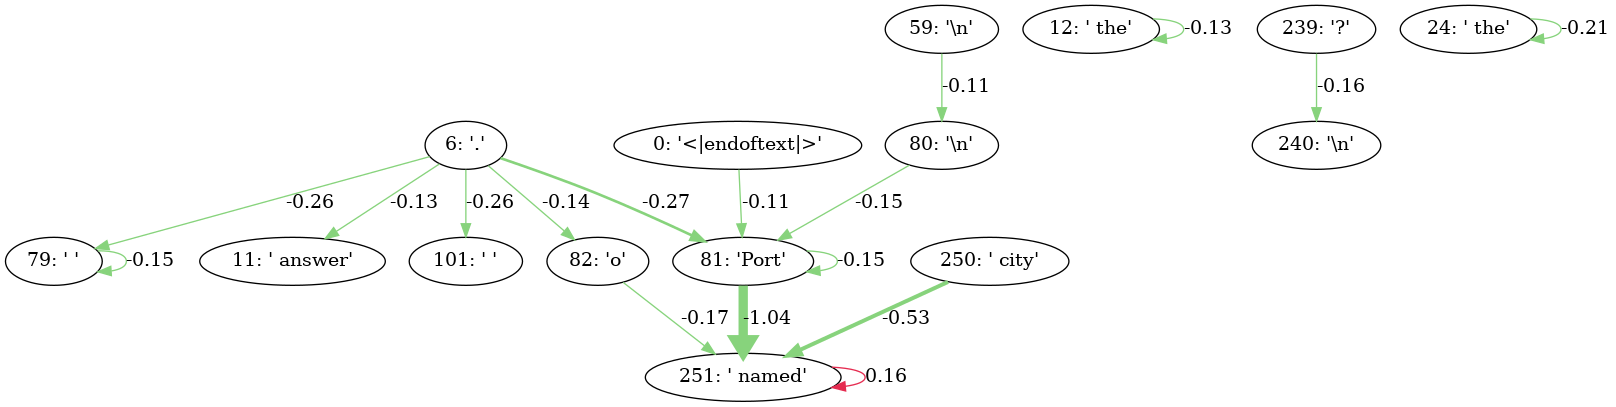

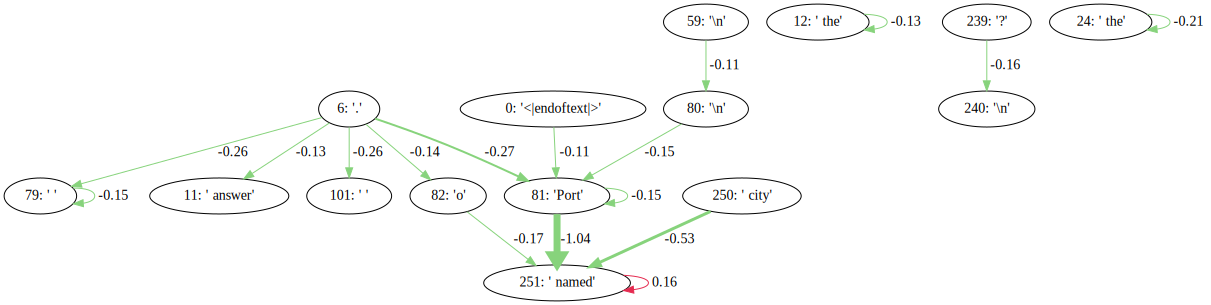

In [19]:
plot_graphviz_connectome(pythia, QA_PROMPT, c, threshold=0.1)

In [ ]:
# %%
# %%
# graph = core.plot_graphviz_connectome(pythia, CODE2, c, threshold=threshold).pipe('svg').decode('utf-8')
# SVG(graph)
# %%
plot_graphviz_connectome(pythia, CODE_PROMPT, c, threshold=0.5)
# Image(graph)
# %%
plot_attn_connectome(pythia, CODE_PROMPT, c).show()
# %%
import plotly.express as px
# %%
_, cache = pythia.run_with_cache(CODE_PROMPT, names_filter=lambda n: n.endswith("pattern"))
avg_attention = torch.stack([
    cache['pattern', layer][0]  # remove batch dim
    for layer in range(pythia.cfg.n_layers)
]).flatten(0,1).quantile(0.99, dim=0)
# ]).max(dim=0).values.max(dim=0).values  # max over heads and layer
# ]).sum(dim=(0,1))

labels = pythia.to_str_tokens(CODE_PROMPT)
labels = [f"{i}: {label!r}" for i, label in enumerate(labels)]
px.imshow(avg_attention[2:,2:].cpu(),
            x=labels[2:],
            y=labels[2:],
            color_continuous_scale="Blues",
            title="Max attention on Pythia Code Completion",
            height=3000).show()
dim=0#%%
torch.save(avg_attention, "avg_attention.pt")
